<a href="https://colab.research.google.com/github/wei-yuan/patent_classification/blob/master/14%E7%BE%A4BertFeatureVectorToCPCNumStat(all_claim).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: From The First Claim of Patent to CPC Number Statistics

## Environment Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 21.5 MB/s 


In [2]:
# You will use the AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 31.3 MB/s 
     |████████████████████████████████| 1.3 MB 57.2 MB/s 
     |████████████████████████████████| 116 kB 78.6 MB/s 
     |████████████████████████████████| 99 kB 10.5 MB/s 
     |████████████████████████████████| 352 kB 74.4 MB/s 
     |████████████████████████████████| 1.1 MB 61.7 MB/s 
     |████████████████████████████████| 238 kB 79.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 


## Import Library

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Load Pre-Trained Model of BERT from The Following Website

* BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
* Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [4]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


The preprocessing model

In [5]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Load Test Text

In [6]:
claimString = ('A method for controlling an electronic apparatus, '
            + 'the method comprising: receiving image data, '
            + "an artificial intelligence (AI) flag indicating whether AI downscaling is performed by an external server, "
            + "and a filter index from the external server; decoding the image data; "
            + "in response to the AI flag being a first value and the filter index being not null, "
            + "upscaling the decoded image data using a first AI model corresponding to the filter index and providing the upscaled image data for output; "
            + "in response to the AI flag being the first value and the filter index being null, " 
            + "upscaling the decoded image data using a default AI model and providing the upscaled image data for output; " 
            + "and in response to the AI flag being not the first value, providing the decoded image data for output without performing an upscaling process, " 
            + "wherein the image data is obtained by encoding downscaled image data acquired " 
            + "by inputting original image data corresponding to the image data into a second AI model for downscaling original image data, " 
            + "wherein a number of filters of the first AI model is smaller than a number of filters of the second AI model, " 
            + "and wherein the first AI model is a Convolutional Neural Network (CNN).")

claimString = claimString.lower()
print(claimString)

a method for controlling an electronic apparatus, the method comprising: receiving image data, an artificial intelligence (ai) flag indicating whether ai downscaling is performed by an external server, and a filter index from the external server; decoding the image data; in response to the ai flag being a first value and the filter index being not null, upscaling the decoded image data using a first ai model corresponding to the filter index and providing the upscaled image data for output; in response to the ai flag being the first value and the filter index being null, upscaling the decoded image data using a default ai model and providing the upscaled image data for output; and in response to the ai flag being not the first value, providing the decoded image data for output without performing an upscaling process, wherein the image data is obtained by encoding downscaled image data acquired by inputting original image data corresponding to the image data into a second ai model for d

Check The Output Of Test Text

In [7]:
text_test = [claimString]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037  4118  2005  9756  2019  4816 14709  1010  1996  4118  9605]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Generate Feature Vector from Test Text

In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9529025   0.4219553  -0.30200565  0.25369322  0.41103542  0.91018903
  0.98970884 -0.4258257  -0.8530155  -0.6909155  -0.5641822  -0.6043148 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.26967818  0.19009256 -0.58130944 ... -1.0642269  -0.33731967
   1.2052778 ]
 [-0.5617297   0.6367726  -0.71991533 ... -0.15618895 -0.8970577
   0.6803122 ]
 [-0.6592203  -0.33713543 -0.1758166  ... -0.11071622  0.22451162
   0.55625623]
 ...
 [-0.33033538  0.18929556 -1.1435122  ... -1.3680378   0.85349894
  -0.40809512]
 [-0.83250505 -0.05499697  0.790687   ... -0.22852843  0.5220619
  -0.3183328 ]
 [-0.46172756  0.04604173 -1.0418929  ...  0.12435526  0.5276506
   0.78420764]]


Mount Drive

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read CSV

In [11]:
import pandas as pd
pd.__version__

'1.3.5'

In [12]:
df = pd.read_csv('gdrive/My Drive/out_sourcing/patent_classification/processed_data/patent_info.csv')     
df.head()

,patent_name,abstract,claim1,cpc number,detailed_description,patent number,claim1_feature_vector,cluster
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...",The invention claimed is: 1. A method compr...,H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507",NaN,NaN
1,Electronic device and method for providing dra...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469",NaN,NaN
2,Electronic device and method for controlling m...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595",NaN,NaN
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,What is claimed is: 1. A stylus pen compris...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582",NaN,NaN
4,Electronic device including helical antenna,"According to various embodiments, an electroni...",What is claimed is: 1. An electronic device...,H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848",NaN,NaN


In [13]:
# create new column for first cpc number
df_cpc_num_list  = df["cpc number"].to_list()
first_cpc_number = list()

for row in df_cpc_num_list:
    # split by semi-colon
    row_split_by_semi =  row.split(';')
    # append the first cpc number to new list
    first_cpc_number.append(row_split_by_semi[0])

df["first cpc number"] = first_cpc_number

In [14]:
df.columns = df.columns.str.replace('claim1', 'all_claim')
df.columns = df.columns.str.replace('claim1_feature_vector', 'all_claim_feature_vector')

In [15]:
df.head()

,patent_name,abstract,all_claim,cpc number,detailed_description,patent number,all_claim_feature_vector,cluster,first cpc number
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...",The invention claimed is: 1. A method compr...,H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507",NaN,NaN,H02J 50/10 (20160201)
1,Electronic device and method for providing dra...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469",NaN,NaN,G09B 11/00 (20130101)
2,Electronic device and method for controlling m...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595",NaN,NaN,G06F 3/04144 (20190501)
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,What is claimed is: 1. A stylus pen compris...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582",NaN,NaN,G06F 3/04166 (20190501)
4,Electronic device including helical antenna,"According to various embodiments, an electroni...",What is claimed is: 1. An electronic device...,H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848",NaN,NaN,H01Q 1/243 (20130101)


# Generate Feature Vector to column all_claim_feature_vector

In [16]:
target_data_column = 'all_claim'  # <--- specify the column data you want
target_series = df[target_data_column] 
target_feature_vector_list = list()

for index, value in target_series.items():
    text_test = [value]
    text_preprocessed = bert_preprocess_model(text_test)
    bert_results = bert_model(text_preprocessed)
    target_feature_vector_list.append(bert_results["pooled_output"].numpy()[0])  # get only 1d vector 

In [17]:
print(f"the number of data in claim1 feature list: {len(target_feature_vector_list)}")
length = 5
for index, vector in enumerate(target_feature_vector_list, start = 1):
    print(f"the vector size: {vector.shape}")
    print(f"the #{index} claim1 feature vector in only {length} digits: {vector[:length]}")
    break

the number of data in claim1 feature list: 1850
the vector size: (512,)
the #1 claim1 feature vector in only 5 digits: [ 0.96963334  0.8729013  -0.0899298   0.1302672   0.42781484]


# K-Means Clustering

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [19]:
from sklearn.cluster import KMeans

number_of_cluster = 14  # <--- input the number of clusters here
kmeans = KMeans(n_clusters = number_of_cluster)
kmeans.fit(target_feature_vector_list)
y_kmeans = kmeans.predict(target_feature_vector_list)

In [20]:
print(f"The class number after K-Means: {y_kmeans}")

The class number after K-Means: [ 9  1  1 ...  6 13  6]


# Dimensional Reduction For High Dimension Vector
The working flow: vector -> PCA -> tSNE

In [21]:
!pip install scprep phate umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████| 88 kB 8.2 MB/s 
     |████████████████████████████████| 416 kB 62.8 MB/s 
     |████████████████████████████████| 45 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 53.8 MB/s 
     |████████████████████████████████| 1.1 MB 93.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=756070d5897dd286125b08d546e7fb96a380adfa044faecfbed7779e6919219e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=9a942434eced3266228b3c8bdfd4527f0511dff5219da9579fb01067847bf526
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-lea

In [22]:
import scprep

In [23]:
# Speed it up by running PCA to 50 dimensions.
data = np.array(target_feature_vector_list)
print(f"The data shape: {data.shape}")

# n_components must be between 0 and min(n_samples, n_features)=5
n_samples, n_features = data.shape[0], data.shape[1]
data_pca = scprep.reduce.pca(data, n_components=min(n_samples, n_features), method='dense')

The data shape: (1850, 512)


Speed up t-SNE a little further by subsampling

In [24]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


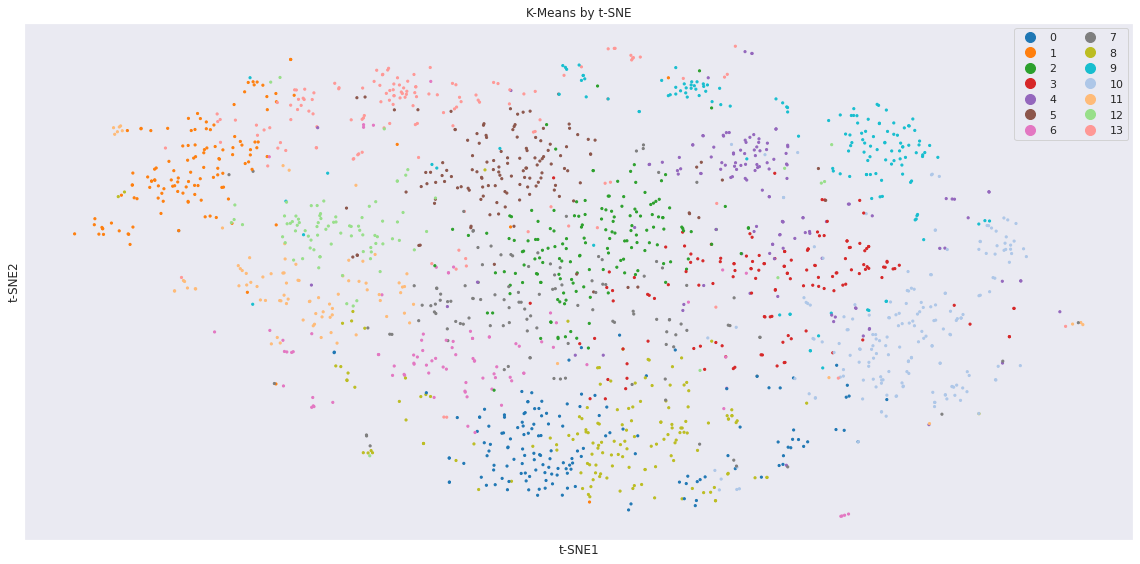

In [25]:
scprep.plot.scatter2d(data_tsne, c=y_kmeans,
                      figsize=(16,8), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE', 
                      title="K-Means by t-SNE")

Update New Series Data To Dataframe

In [26]:
c_series = pd.Series(target_feature_vector_list)
print(f"{target_data_column} feature vector: {c_series}")

all_claim feature vector: 0       [0.96963334, 0.8729013, -0.089929804, 0.130267...
1       [0.87070775, 0.66626453, -0.38230348, 0.334020...
2       [0.9307277, 0.6644645, -0.08659923, 0.4133929,...
3       [0.988569, 0.6360154, -0.1090255, 0.14666589, ...
4       [0.9868581, 0.20076929, 0.12633972, 0.12246182...
                              ...                        
1845    [0.8801989, 0.61628556, 0.027897168, 0.3352506...
1846    [0.99603766, 0.25535977, 0.086981945, 0.164781...
1847    [0.99297607, 0.13013671, 0.08688028, 0.1373852...
1848    [0.969812, 0.8777523, -0.1145577, 0.20512827, ...
1849    [0.98353374, 0.9279252, 0.10644194, -0.0319289...
Length: 1850, dtype: object


In [27]:
# update claim 1 feature vector
df["all_claim_feature_vector"] = c_series

In [28]:
print(df["all_claim_feature_vector"])

0       [0.96963334, 0.8729013, -0.089929804, 0.130267...
1       [0.87070775, 0.66626453, -0.38230348, 0.334020...
2       [0.9307277, 0.6644645, -0.08659923, 0.4133929,...
3       [0.988569, 0.6360154, -0.1090255, 0.14666589, ...
4       [0.9868581, 0.20076929, 0.12633972, 0.12246182...
                              ...                        
1845    [0.8801989, 0.61628556, 0.027897168, 0.3352506...
1846    [0.99603766, 0.25535977, 0.086981945, 0.164781...
1847    [0.99297607, 0.13013671, 0.08688028, 0.1373852...
1848    [0.969812, 0.8777523, -0.1145577, 0.20512827, ...
1849    [0.98353374, 0.9279252, 0.10644194, -0.0319289...
Name: all_claim_feature_vector, Length: 1850, dtype: object


In [29]:
# update cluster number
df["cluster"] = y_kmeans

In [30]:
df.head(10)

,patent_name,abstract,all_claim,cpc number,detailed_description,patent number,all_claim_feature_vector,cluster,first cpc number
0,Camera with reduced image noise resulting from...,"An example method includes receiving, by a mob...",The invention claimed is: 1. A method compr...,H02J 50/10 (20160201); H04N 5/247 (20130101); ...,BACKGROUND Some computing devices include a ...,"11,329,507","[0.96963334, 0.8729013, -0.089929804, 0.130267...",9,H02J 50/10 (20160201)
1,Electronic device and method for providing dra...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G09B 11/00 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,328,469","[0.87070775, 0.66626453, -0.38230348, 0.334020...",1,G09B 11/00 (20130101)
2,Electronic device and method for controlling m...,An electronic device according to various embo...,The invention claimed is: 1. An electronic ...,G06F 3/04144 (20190501); G06F 3/04883 (2013010...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,327,595","[0.9307277, 0.6644645, -0.08659923, 0.4133929,...",1,G06F 3/04144 (20190501)
3,"Stylus pen, touch apparatus, and touch system",An exemplary embodiment of the present inventi...,What is claimed is: 1. A stylus pen compris...,G06F 3/04166 (20190501); G06F 3/0445 (20190501...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,327,582","[0.988569, 0.6360154, -0.1090255, 0.14666589, ...",3,G06F 3/04166 (20190501)
4,Electronic device including helical antenna,"According to various embodiments, an electroni...",What is claimed is: 1. An electronic device...,H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848","[0.9868581, 0.20076929, 0.12633972, 0.12246182...",0,H01Q 1/243 (20130101)
5,"Display device, user terminal device, method f...",The present disclosure relates to a display de...,What is claimed is: 1. A display device com...,G11B 27/34 (20130101); G06F 3/1423 (20130101);...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,321,040","[0.8752701, 0.9517045, -0.14265786, 0.14807574...",2,G11B 27/34 (20130101)
6,Sensing device with fingerprint sensor,A sensing device with a fingerprint sensor is ...,What is claimed is: 1. A sensing device com...,H03K 17/962 (20130101); H03H 17/0671 (20130101...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,320,941","[0.99223393, 0.3618843, -0.27200845, 0.1311185...",3,H03K 17/962 (20130101)
7,Electronic device including antenna module,An electronic device includes: a housing inclu...,What is claimed is: 1. An electronic device...,H01Q 1/38 (20130101); H01Q 1/02 (20130101); H0...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,316,284","[0.96181107, 0.3028212, 0.068707004, 0.0478640...",0,H01Q 1/38 (20130101)
8,Operating method of electronic device for func...,An operating method of an electronic device fo...,What is claimed is: 1. An electronic device...,G06F 21/32 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,314,898","[0.9796734, 0.69571054, -0.049645085, 0.311351...",0,G06F 21/32 (20130101)
9,Display device and method of driving the same ...,A display device including a display panel hav...,"What is claimed is: 1. A display device, co...",G06F 3/0412 (20130101); G09G 3/20 (20130101); ...,BACKGROUND Field Exemplary embodiments of th...,"11,314,368","[0.96506613, -0.6038193, 0.08270588, 0.3539253...",8,G06F 3/0412 (20130101)


In [31]:
df.count()

patent_name                 1850
abstract                    1850
all_claim                   1850
cpc number                  1850
detailed_description        1850
patent number               1850
all_claim_feature_vector    1850
cluster                     1850
first cpc number            1850
dtype: int64

In [42]:
from pathlib import Path

output_path = 'gdrive/My Drive/out_sourcing/patent_classification/result'
file_name = f'patent_info_{target_data_column}_all.csv'
df.to_csv(Path(output_path).joinpath(file_name), index=False)

## Label Classification By Cluster Number

Pick cluster 0 as our observation target

In [33]:
# select cluster number
cluster_unique = df["cluster"].unique().tolist()
cluster_unique.sort()  # sort in the acsending way
print(f"cluster number: {cluster_unique}")

for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    break

cluster number: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cluster number: 0


In [34]:
# check the result of cluster 0
single_cluster.head()

,patent_name,abstract,all_claim,cpc number,detailed_description,patent number,all_claim_feature_vector,cluster,first cpc number
4,Electronic device including helical antenna,"According to various embodiments, an electroni...",What is claimed is: 1. An electronic device...,H01Q 1/243 (20130101); H01Q 1/38 (20130101); H...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,322,848","[0.9868581, 0.20076929, 0.12633972, 0.12246182...",0,H01Q 1/243 (20130101)
7,Electronic device including antenna module,An electronic device includes: a housing inclu...,What is claimed is: 1. An electronic device...,H01Q 1/38 (20130101); H01Q 1/02 (20130101); H0...,CROSS-REFERENCE TO RELATED APPLICATION This ...,"11,316,284","[0.96181107, 0.3028212, 0.068707004, 0.0478640...",0,H01Q 1/38 (20130101)
8,Operating method of electronic device for func...,An operating method of an electronic device fo...,What is claimed is: 1. An electronic device...,G06F 21/32 (20130101); G06F 3/04883 (20130101)...,CROSS-REFERENCE TO RELATED APPLICATIONS This...,"11,314,898","[0.9796734, 0.69571054, -0.049645085, 0.311351...",0,G06F 21/32 (20130101)
14,Electronic device including electronic compone...,"In embodiments, an electronic device comprises...",What is claimed is: 1. An electronic device...,H05K 1/189 (20130101); H04N 5/2257 (20130101);...,CROSS-REFERENCE TO RELATED APPLICATION(S) Th...,"11,310,400","[0.99009216, 0.31725544, -0.015410416, 0.11730...",0,H05K 1/189 (20130101)
22,Stylus pen,An exemplary embodiment of the present inventi...,What is claimed is: 1. A stylus pen compris...,G06F 3/03545 (20130101); H01F 17/045 (20130101...,BACKGROUND OF THE INVENTION (a) Field of the ...,"11,301,062","[0.9766657, 0.52104056, -0.19616774, -0.054487...",0,G06F 3/03545 (20130101)


CPC Number Category
* Section: F
* Class: F02
* Sub-class: F02D
* Group: F02D 41
* Sub-Group: F02D 41/02

In [35]:
# read each row data in cpc number
cpc_number_list = single_cluster["cpc number"].tolist()
print(f"Number of element in cpc_number_list: {len(cpc_number_list)}")
print(f"The content of cpc_number_list: {cpc_number_list}")

Number of element in cpc_number_list: 152
The content of cpc_number_list: ['H01Q 1/243 (20130101); H01Q 1/38 (20130101); H04B 5/0081 (20130101); H01Q 11/08 (20130101); H01Q 1/2208 (20130101)', 'H01Q 1/38 (20130101); H01Q 1/02 (20130101); H01Q 21/065 (20130101); H01Q 1/2283 (20130101); H01Q 21/28 (20130101); H01Q 1/526 (20130101); H01Q 21/062 (20130101); H01Q 1/243 (20130101)', 'G06F 21/32 (20130101); G06F 3/04883 (20130101); G07C 9/257 (20200101); G10L 15/22 (20130101); G06V 40/1365 (20220101); G06V 40/172 (20220101); G07C 9/27 (20200101); H04L 63/0861 (20130101); G06F 3/167 (20130101); H04M 1/67 (20130101); G06V 40/197 (20220101); G06F 21/629 (20130101); G07C 9/26 (20200101); G10L 2015/223 (20130101); H04M 2250/74 (20130101)', 'H05K 1/189 (20130101); H04N 5/2257 (20130101); G06F 1/1686 (20130101); H05K 1/028 (20130101); G06F 1/1626 (20130101); H04N 5/2252 (20130101); H04N 5/2258 (20130101); H05K 2201/10356 (20130101); H05K 2201/10151 (20130101); H05K 2201/10121 (20130101); H05K 2201/1

In [36]:
def cpc_num_stat(mode: str, cpc_number_list: list, simple_cpc_number_dict: dict):    
    for row in cpc_number_list:
        # split by semi-colon
        row_split_by_semi =  row.split(';')
        for row in row_split_by_semi:        
            cpc_num_set = set()      
            # split by space
            row_split = row.split(' ')        
            row_split_filtered_empty_string = [x for x in row_split if x]
            # to sub-class level
            sub_class = row_split_filtered_empty_string[0]      
            # # to sub-group level
            sub_group = ' '.join(row_split_filtered_empty_string[:2])  # stop until the date information

            if MODE == 'SUB-CLASS':
                data = sub_class
            elif MODE == 'SUB-GROUP':
                data = sub_group

            # add to simple_cpc_number_dict          
            if sub_class not in simple_cpc_number_dict:
                simple_cpc_number_dict[data] = 1
            else:
                simple_cpc_number_dict[data] += 1
    return simple_cpc_number_dict

In [37]:
# switch mode here
MODE = 'SUB-CLASS'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

Observe cluster Statistics in SUB-CLASS level

In [38]:
print(result)

{'H01Q': 125, 'H04B': 50, 'G06F': 409, 'G07C': 3, 'G10L': 2, 'G06V': 10, 'H04L': 5, 'H04M': 60, 'H05K': 74, 'H04N': 39, 'H01F': 34, 'G09G': 33, 'G02B': 29, 'G03B': 29, 'H01L': 10, 'H02J': 55, 'H04R': 53, 'G01L': 4, 'A61N': 2, 'A61B': 18, 'H02H': 1, 'H01R': 24, 'H04W': 13, 'G10K': 1, 'H01P': 15, 'A45F': 2, 'A44B': 1, 'H02K': 3, 'G01B': 2, 'Y02E': 2, 'F24F': 10, 'G01K': 2, 'Y02B': 1, 'B43K': 24, 'Y10T': 7, 'H01M': 4, 'G01R': 2, 'F16M': 9, 'F16F': 1, 'E05Y': 2, 'H03K': 1, 'G06Q': 11, 'Y02P': 1, 'H04J': 1, 'G06K': 1, 'E05D': 2, 'G09F': 1, 'G06T': 1, 'A61M': 1, 'H01H': 2, 'G02F': 7, 'A43B': 3, 'B01J': 1, 'A43D': 2, 'Y10S': 4, 'B82Y': 1, 'A45C': 4, 'B60N': 1, 'B60R': 1, 'B81B': 2, 'B41J': 1, 'B24B': 1, 'E04B': 3, 'A47B': 1}


Observe in finer grained SUB-GROUP level

In [39]:
# switch mode here
MODE = 'SUB-GROUP'
stat_dictionary = dict()
result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)

In [40]:
print(result)

{'H01Q 1/243': 1, 'H01Q 1/38': 1, 'H04B 5/0081': 1, 'H01Q 11/08': 1, 'H01Q 1/2208': 1, 'H01Q 1/02': 1, 'H01Q 21/065': 1, 'H01Q 1/2283': 1, 'H01Q 21/28': 1, 'H01Q 1/526': 1, 'H01Q 21/062': 1, 'G06F 21/32': 1, 'G06F 3/04883': 1, 'G07C 9/257': 1, 'G10L 15/22': 1, 'G06V 40/1365': 1, 'G06V 40/172': 1, 'G07C 9/27': 1, 'H04L 63/0861': 1, 'G06F 3/167': 1, 'H04M 1/67': 1, 'G06V 40/197': 1, 'G06F 21/629': 1, 'G07C 9/26': 1, 'G10L 2015/223': 1, 'H04M 2250/74': 1, 'H05K 1/189': 1, 'H04N 5/2257': 1, 'G06F 1/1686': 1, 'H05K 1/028': 1, 'G06F 1/1626': 1, 'H04N 5/2252': 1, 'H04N 5/2258': 1, 'H05K 2201/10356': 1, 'H05K 2201/10151': 1, 'H05K 2201/10121': 1, 'H05K 2201/10189': 1, 'G06F 3/03545': 1, 'H01F 17/045': 1, 'G06F 3/0441': 1, 'H01F 1/0315': 1, 'H01F 27/2823': 1, 'G06F 3/0442': 1, 'H01Q 21/00': 1, 'H01Q 21/08': 1, 'H05K 1/0298': 1, 'H05K 7/20336': 1, 'H05K 1/0206': 1, 'H05K 2201/10098': 1, 'G06F 3/0445': 1, 'G06F 3/046': 1, 'G06F 3/0418': 1, 'G06F 3/044': 1, 'G06F 3/0446': 1, 'G09G 3/344': 1, 'G06F

# iterate all class

In [41]:
# iterate each cluster number
for cluster_num in cluster_unique:
    print(f"cluster number: {cluster_num}")
    single_cluster = df[df["cluster"] == cluster_num]
    cpc_number_list = single_cluster["cpc number"].tolist()
    # switch mode here
    MODE = 'SUB-CLASS'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary) 
    print(f"CPC number stats in sub-class level: {result}")
    
    result = None
    # switch mode here
    MODE = 'SUB-GROUP'
    stat_dictionary = dict()
    result = cpc_num_stat(MODE, cpc_number_list, stat_dictionary)    
    print(f"CPC number stats in sub-group level: {result}\n")        

cluster number: 0
CPC number stats in sub-class level: {'H01Q': 125, 'H04B': 50, 'G06F': 409, 'G07C': 3, 'G10L': 2, 'G06V': 10, 'H04L': 5, 'H04M': 60, 'H05K': 74, 'H04N': 39, 'H01F': 34, 'G09G': 33, 'G02B': 29, 'G03B': 29, 'H01L': 10, 'H02J': 55, 'H04R': 53, 'G01L': 4, 'A61N': 2, 'A61B': 18, 'H02H': 1, 'H01R': 24, 'H04W': 13, 'G10K': 1, 'H01P': 15, 'A45F': 2, 'A44B': 1, 'H02K': 3, 'G01B': 2, 'Y02E': 2, 'F24F': 10, 'G01K': 2, 'Y02B': 1, 'B43K': 24, 'Y10T': 7, 'H01M': 4, 'G01R': 2, 'F16M': 9, 'F16F': 1, 'E05Y': 2, 'H03K': 1, 'G06Q': 11, 'Y02P': 1, 'H04J': 1, 'G06K': 1, 'E05D': 2, 'G09F': 1, 'G06T': 1, 'A61M': 1, 'H01H': 2, 'G02F': 7, 'A43B': 3, 'B01J': 1, 'A43D': 2, 'Y10S': 4, 'B82Y': 1, 'A45C': 4, 'B60N': 1, 'B60R': 1, 'B81B': 2, 'B41J': 1, 'B24B': 1, 'E04B': 3, 'A47B': 1}
CPC number stats in sub-group level: {'H01Q 1/243': 1, 'H01Q 1/38': 1, 'H04B 5/0081': 1, 'H01Q 11/08': 1, 'H01Q 1/2208': 1, 'H01Q 1/02': 1, 'H01Q 21/065': 1, 'H01Q 1/2283': 1, 'H01Q 21/28': 1, 'H01Q 1/526': 1, 'H01Q 2